In [13]:
import os
import fnmatch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from lr_video_face.plots import *

from lir import Xy_to_Xn, metrics

In [14]:

home = os.path.expanduser("~")

# SQL database path and name
input_dir = os.path.join(home, 'video_resources', 'sql_database')
#db_name = 'colab_main_dataset'
# Where results are saved
output_dir = os.path.join(home, 'video_resources', 'exp_output_SCFACELFW_nofiltros')

#Traducción de nombres
dic_emb = {'Facenet512': 'FaceNet', 'QMagFace':'QMagFace', 'ArcFace':'ArcFace'}
dic_qua = {'tface' : 'SDD-FIQA','ser_fiq': 'SER-FIQ'}

In [15]:

files = []
for root, dir, filenames in os.walk(output_dir):
    for filename in fnmatch.filter(filenames, 'dat*.pd'):
        files.append(os.path.join(root, filename))
   

In [16]:
def generate_plot(file):

    df0 = pd.read_pickle(file)

    if len(pd.unique(df0.Detector)) == 1 and len(pd.unique(df0.Calibrator)) == 1:

        cols = list(pd.unique(df0['Embedding Model']))
        rows = list(pd.unique(df0['Quality Model']))

        #generamos la gráfica con subplots
        fig,ax = plt.subplots(nrows = len(rows), ncols = len(cols), squeeze= False, figsize= (25,10))
        
        for index, df1 in df0.iterrows():

            col = cols.index(df1['Embedding Model'])
            row = rows.index(df1['Quality Model'])

            ax1 = ax[row][col]
            #ax1.ylabel = df1['Embedding Model']
            #ax1.set_title ( f"Quality Model: {dic_qua [df1['Quality Model']]}")
            ax1.set_title ( f"Embedding Model: {dic_emb [df1['Embedding Model']]}",fontsize = 14)

            subplot_new(ax1,df1.Results, df1.Cllr)
            #ax1.set(ylabel= f"Embedding Model: {dic_emb[df1['Embedding Model']]}\n Cllr")
            
            #ax1.set(ylabel= f"Quality Model: {dic_qua[df1['Quality Model']]}\n Cllr")
            ax1.set_ylabel(f"Quality Model: {dic_qua[df1['Quality Model']]}\n Cllr",fontsize = 14)
            ax1.set_xlabel('% of discarded pairs',fontsize=14)
        plt.suptitle('$C_{llr}$ Values',fontsize=18)

        #leyenda global
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, borderaxespad=0.)
        fig.tight_layout()
        #savefig = os.path.join(self.experiments.output_dir, f"cllr_summary_ESX{self.experiments.embedding_model_as_scorer}")
        savefig = os.path.join(os.path.dirname(file), os.path.splitext(file)[0]+'_v4')
        plt.savefig(savefig, dpi=600)
        plt.close() 

In [17]:
def generate_latex(file):
    df0 = pd.read_pickle(file)


    
    

    if len(pd.unique(df0.Detector)) == 1 and len(pd.unique(df0.Calibrator)) == 1:
        df_latex = pd.DataFrame()

        for index, df1 in df0.iterrows():    

            emb_model = df1['Embedding Model']
            qua_model = df1['Quality Model']
            # the results are only received for 2015
            lrs_predicted = df1.Results["lrs_predicted"]
            y_test = df1.Results["y_test"]
            dropouts = df1.Results["quality_drops"]
            common_attributes = df1.Results['common_attributes']
    
            cllr_participants = np.mean(df1.Cllr)

            # imagen promedio (17 comparisons)
            lr_avg = df1.Results["lrs_predicted_2015"]
            y_avg = df1.Results["y_test_2015"]    
    
            cllr_avg = metrics.cllr(np.asarray(lr_avg), np.asarray(y_avg)) 
            df_latex = df_latex.append({'Embedding_model': 'Participants',
                                            'Quality_model': dic_qua[qua_model],
                                             'Cllr': cllr_participants},ignore_index = True)
            df_latex = df_latex.append({'Embedding_model': 'Average Image',
                                            'Quality_model': dic_qua[qua_model],
                                             'Cllr': cllr_avg},ignore_index = True)

            #get cllr per dropout

            
            for d in set(dropouts):
                lr_d = [lr for lr,dropout in zip(lrs_predicted,dropouts) if dropout== d ]
                y_d = [y for y,dropout in zip(y_test,dropouts) if dropout== d ]
                cllr_d = metrics.cllr(np.asarray(lr_d), np.asarray(y_d))

            #solo cambio en el momento de plotear
                df_latex = df_latex.append({'Embedding_model': dic_emb[emb_model],
                                            'Quality_model': dic_qua[qua_model],
                                             'Cllr': cllr_d,
                                             'Dropout': 100*(1-d)},ignore_index = True)

            df_latex.sort_values(by= 'Dropout', inplace = True)
            #df_latex.dropna(inplace= True)

            

            # get cllr per common attributes
            # filter results when dropout = 1 
            lrs = [lr for lr,drop in zip(lrs_predicted,dropouts) if drop== 1] 
            ys = [y for y,drop in zip(y_test,dropouts) if drop== 1]
            comatt = [ca for ca,drop in zip(common_attributes,dropouts) if drop== 1]


            #df_plot2 = pd.DataFrame()
            for c in set(comatt):
                lr_c = [lr for lr,com in zip(lrs,comatt) if com== c ]
                y_c = [y for y,comm in zip(ys,comatt) if comm== c ]
                cllr_c = metrics.cllr(np.asarray(lr_c), np.asarray(y_c))
                df_latex = df_latex.append({'Embedding_model': dic_emb[emb_model],
                                            'Quality_model': dic_qua[qua_model],
                                             'Cllr': cllr_c,
                                             'Common Attributes': c},ignore_index = True)
        
            df_latex.sort_values(by= 'Common Attributes', inplace = True)
            #df_latex.dropna(inplace= True)   

#----
        latex_table = df_latex.to_latex(index=False)
        savelatex = os.path.join(os.path.dirname(file), os.path.splitext(file)[0]+'.tex')

        with open (savelatex,'w') as f:
            f.write(latex_table)

/home/jmacarulla/lr-video-face/lr_video_face/plots.py:430: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot1 = df_plot1.append({'dropout': 100*(1-d), 'Cllr': cllr_d1,'Cllr2': cllr_d2},ignore_index = True)
/home/jmacarulla/lr-video-face/lr_video_face/plots.py:430: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot1 = df_plot1.append({'dropout': 100*(1-d), 'Cllr': cllr_d1,'Cllr2': cllr_d2},ignore_index = True)
/home/jmacarulla/lr-video-face/lr_video_face/plots.py:430: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot1 = df_plot1.append({'dropout': 100*(1-d), 'Cllr': cllr_d1,'Cllr2': cllr_d2},ignore_index = True)
/home/jmacarulla/lr-video-face/lr_video_face/plots.py:430: FutureWarning: The frame.append method is de

TypeError: got an unexpected keyword argument 'label'

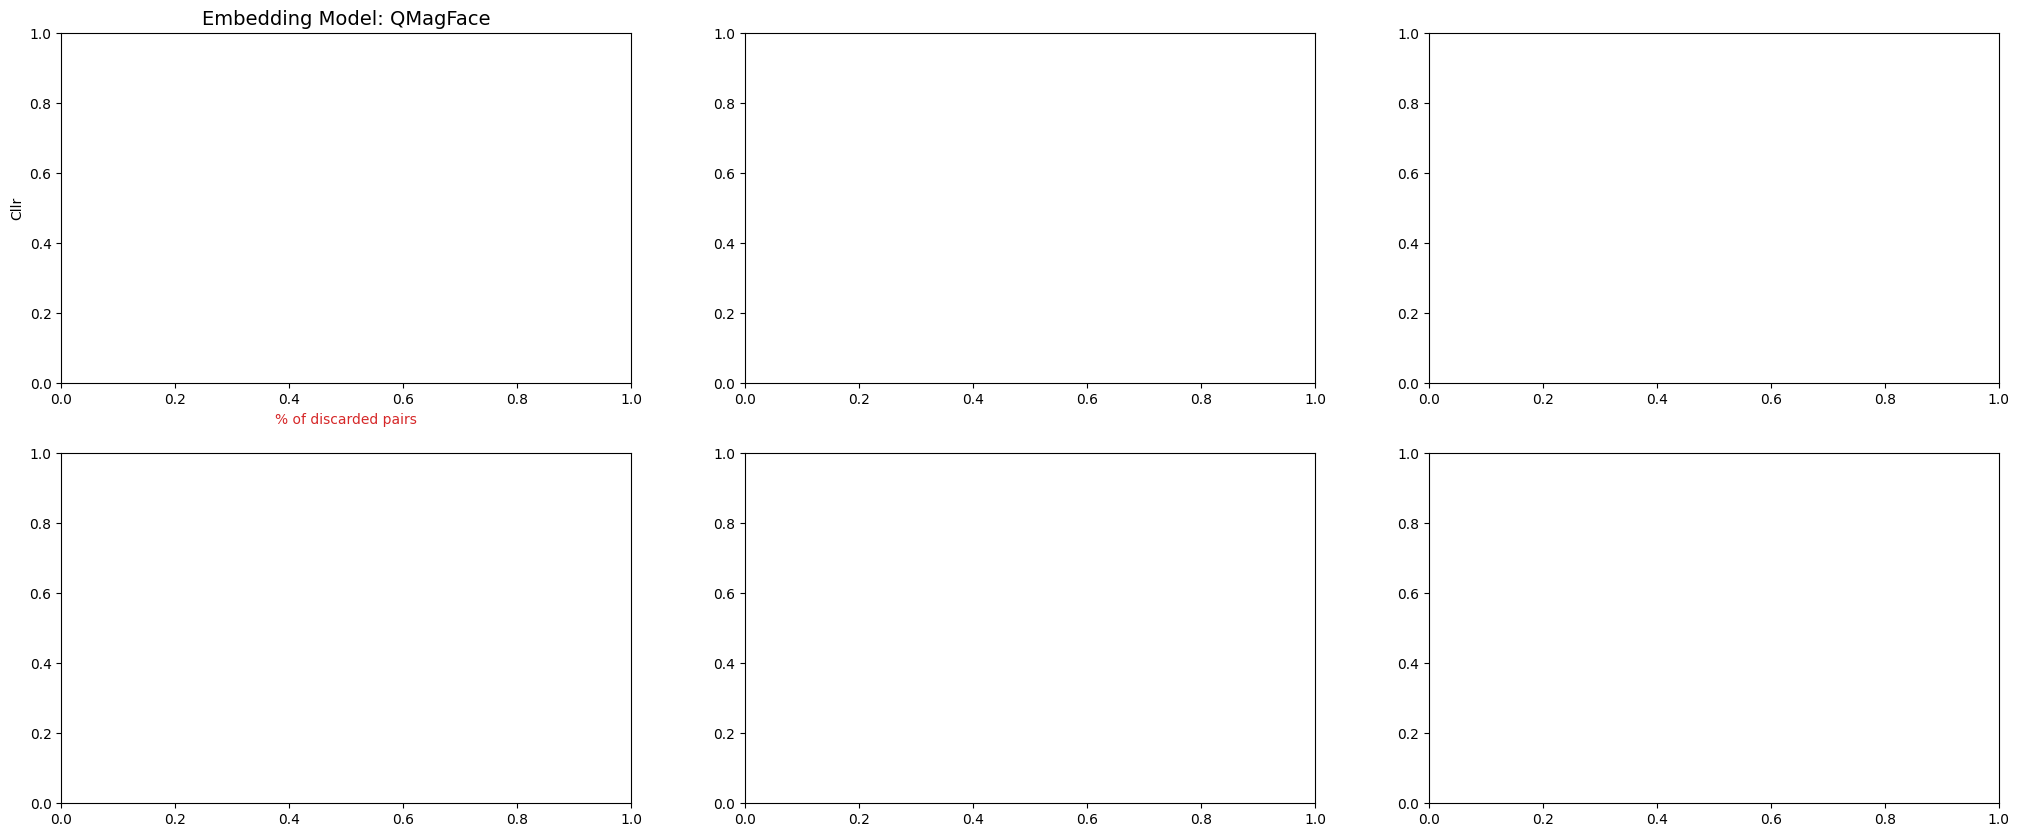

In [18]:
for file in files:
    generate_plot(file)
    generate_latex(file)
